In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,4)
import pandas as pd
pd.set_option('display.max_columns', 50)

import category_encoders as ce
from datetime import datetime, timedelta
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

In [2]:
df = pd.read_csv('data.csv')

### Class Proportions (Response = 'ordersuccess')

In [3]:
success = df[df['ordersuccess']==1]
fail = df[df['ordersuccess']==0]

success_num = len(success)
fail_num = len(fail)
total = len(df)

print('Number of order successes: ', success_num)
print('Proportion of order successes: ', success_num / (success_num + fail_num))
print('Number of order failures: ', fail_num)
print('Proportion of order failures: ', fail_num / (success_num + fail_num))

Number of order successes:  28190
Proportion of order successes:  0.05021044213331149
Number of order failures:  533247
Proportion of order failures:  0.9497895578666885


## Preprocessing

In [4]:
def getTimeMS(t):
    if '.' in t:
        timestamp, ms = t.split('.')
    else:
        timestamp = t
        ms = 0
    time_obj = datetime.strptime(timestamp, '%H:%M:%S')
    epoch = datetime(1900, 1, 1, 0, 0, 0, 0)
    milliseconds = (time_obj - epoch) // timedelta(milliseconds=1)
    return milliseconds + float(ms)*1000

df['time_ms'] = df['starttime'].apply(lambda x: getTimeMS(x))
df['adv20d'] = df.loc[:,'adv20d'].fillna(0)

#continuous features
cont_features = df.loc[:,['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                          'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                          'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min', 'adv20d']]

#one-hot encoded features
dummies = pd.get_dummies(df.loc[:,['side','venuetype','securitycategory', 'peginstruction',
                                   'sector','mktcap']].astype('category'),drop_first=True)

#binary encoded features
enc = ce.BinaryEncoder()
binary_sym = enc.fit_transform(df.loc[:,'symbol'].as_matrix())
names = {'0_0':'symbol_0', '0_1':'symbol_1','0_2':'symbol_2','0_3':'symbol_3','0_4':'symbol_4',
         '0_5':'symbol_5','0_6':'symbol_6','0_7':'symbol_7','0_8':'symbol_8','0_9':'symbol_9',
         '0_10':'symbol_10','0_11':'symbol_11','0_12':'symbol_12'}
binary_sym = binary_sym.rename(columns=names)

binary_venue = enc.fit_transform(df.loc[:,'venue'].as_matrix())
names = {'0_0':'venue_0', '0_1':'venue_1','0_2':'venue_2',
         '0_3':'venue_3','0_4':'venue_4','0_5':'venue_5','0_6':'venue_6'}
binary_venue = binary_venue.rename(columns=names)


features = pd.concat([cont_features, dummies, binary_sym, binary_venue], axis=1)
response = df.loc[:,'ordersuccess']
df = pd.concat([features,response],axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Train / Test Split

In [5]:
df = df.sample(frac=1)
train = df.head(round(total*.70))
train = train.reset_index(drop=True)
test = df.tail(round(total*.30))
test = test.reset_index(drop=True)

#get Z scores for training data
cont_features = ['time_ms','size','minexecqty','limitprice','prevailbid','prevailask','prevailbidsize','prevailasksize',
                      'dispatcherrebalance','lotsize','averagespread','misavgbidsize1min','misavgasksize1min', 
                      'misavgspread1min', 'misoddlotvolume1min', 'misadfvolume1min','misvolume1min', 'adv20d']
scaler = StandardScaler().fit(train.loc[:,cont_features])
Z = pd.DataFrame(scaler.transform(train.loc[:, cont_features]))
train_categories = train[train.columns[~train.columns.isin(cont_features)]]   
train_Z = pd.concat([Z, train_categories], axis=1)

#get Z scores for testing data
scaler = StandardScaler().fit(test.loc[:,cont_features])
Z = pd.DataFrame(scaler.transform(test.loc[:, cont_features]))
test_categories = test[test.columns[~test.columns.isin(cont_features)]]   
test_Z = pd.concat([Z, test_categories], axis=1)

#split rows by class
train_success = train[train['ordersuccess']==1]
train_success_Z = train_Z[train_Z['ordersuccess']==1]
train_fail = train[train['ordersuccess']==0]
train_fail_Z = train_Z[train_Z['ordersuccess']==0]

test_success = test[test['ordersuccess']==1]
test_success_Z = test_Z[test_Z['ordersuccess']==1]
test_fail = test[test['ordersuccess']==0]
test_fail_Z = test_Z[test_Z['ordersuccess']==0]

## Downsampling

In [6]:
downsampled_fails = train_fail.sample(n=len(train_success))

#recombine and shuffle data
train_downsampled = pd.concat([downsampled_fails, train_success],axis=0)
train_downsampled = train_downsampled.sample(frac=1).reset_index(drop=True)
# display(train_downsampled.head())


downsampled_fails_Z = train_fail_Z.sample(n=len(train_success_Z))

#recombine and shuffle data
train_downsampled_Z = pd.concat([downsampled_fails_Z, train_success_Z],axis=0)
train_downsampled_Z = train_downsampled_Z.sample(frac=1).reset_index(drop=True)
# display(train_downsampled_Z.head())

## More Data Preparation

In [7]:
train_features = train_downsampled.loc[:,train_downsampled.columns != 'ordersuccess']
train_response = train_downsampled.loc[:,'ordersuccess']

test_features = test.loc[:,test.columns != 'ordersuccess']
test_response = test.loc[:,'ordersuccess']


train_features_Z = train_downsampled_Z.loc[:,train_downsampled_Z.columns != 'ordersuccess']
train_response_Z = train_downsampled_Z.loc[:,'ordersuccess']

test_features_Z = test_Z.loc[:,test_Z.columns != 'ordersuccess']
test_response_Z = test_Z.loc[:,'ordersuccess']

## Model Evaluation Functions

In [8]:
def cm2df(cm, labels): 
    """converts a numpy array confusion matrix to a pandas dataframe, with class labels"""
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

def model_eval(y_test, y_pred): 
    """prints out a confusion matrix (pandas dataframe) and classification report"""
    conf_mat = confusion_matrix(y_test, y_pred)
    cm_as_df=cm2df(conf_mat,[0,1])
    new_names = {0:'Order Fail',1:'Order Success'}
    cm_as_df = cm_as_df.rename(index=new_names, 
                                 columns=new_names)
    print('\n')
    print('CONFUSION MATRIX (predicted along top, actual along side): ')
    display(cm_as_df)

    print('\n')
    print(classification_report(y_test,y_pred,target_names=['Order Fail','Order Success']))
    
def cross_validation(model, features, response, num_folds):
    metrics = ['precision_macro', 'recall_macro', "f1_macro"]
    cv = cross_validate(model, features, response, scoring=metrics, cv=num_folds)
    print("Test data set average precision across 5 folds:")
    print(cv['test_precision_macro'])
    print("\nTest data set average recall across 5 folds:")
    print(cv['test_recall_macro'])
    print("\nTest data set average fscore across 5 folds:")
    print(cv['test_f1_macro'])
    
def plot_roc_curve(model, X_test, y_test):
    probabilities = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probabilities)
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    # plot no skill curve
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Logistic Regression



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,107065,52921
Order Success,2376,6069




               precision    recall  f1-score   support

   Order Fail       0.98      0.67      0.79    159986
Order Success       0.10      0.72      0.18      8445

  avg / total       0.93      0.67      0.76    168431

AUC: 0.737


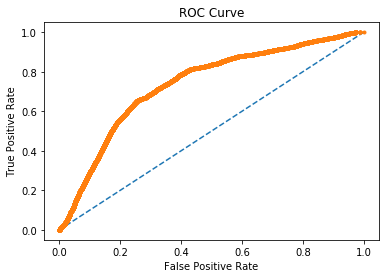

In [9]:
logreg = LogisticRegression()

logreg.fit(train_features, train_response)

y_pred = logreg.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(logreg, test_features, test_response)

# cross_validation(logreg, features, response, 5)

## Decision Tree



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,125821,34165
Order Success,1599,6846




               precision    recall  f1-score   support

   Order Fail       0.99      0.79      0.88    159986
Order Success       0.17      0.81      0.28      8445

  avg / total       0.95      0.79      0.85    168431

AUC: 0.799


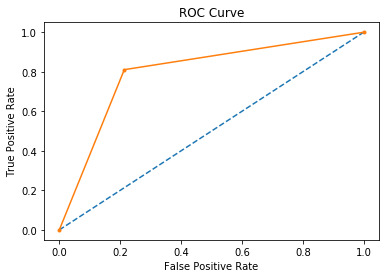

In [10]:
CART = DecisionTreeClassifier()

CART.fit(train_features, train_response)

y_pred = CART.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(CART, test_features, test_response)

# cross_validation(CART, features, response, 5)

## Random Forest



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,133123,26863
Order Success,1282,7163




               precision    recall  f1-score   support

   Order Fail       0.99      0.83      0.90    159986
Order Success       0.21      0.85      0.34      8445

  avg / total       0.95      0.83      0.88    168431

AUC: 0.917


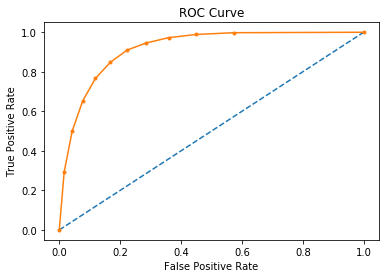

In [11]:
RF = RandomForestClassifier()

RF.fit(train_features, train_response)

y_pred = RF.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(RF, test_features, test_response)

# cross_validation(RF, features, response, 5)

## Tune Random Forest Params with Randomized Grid Search

In [15]:
# import numpy as np
# from pprint import pprint
# from sklearn.model_selection import RandomizedSearchCV

# n_estimators = [50, 100, 200, 400] # Number of trees in random forest
# max_features = ['auto', 'log2', None] # Number of features to consider at every split  #'auto' = sqrt(n_features)
# max_depth = [int(x) for x in np.linspace(10, 100, num = 10)] # Maximum number of levels in tree
# max_depth.append(None)
# min_samples_split = [2, 5, 10, 15] # Minimum number of samples required to split a node
# min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
# bootstrap = [True, False] # Method of selecting samples for training each tree

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [50, 100, 200, 400]}


In [16]:
# RF = RandomForestClassifier()

# # the metric used to select the best parameters
# # f2_score = make_scorer(fbeta_score, beta=1, pos_label=1) #beta = 1 (focus on f1 score), pos_label = 1 (focus on the 1 class)

# rf_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 150, 
#                                cv = 3, verbose=2, scoring="f1_macro", random_state=42, n_jobs = -1)

# rf_random.fit(train_features, train_response)
# rf_random.best_params_

# # best params with cv=4, iterations=150
# # {'n_estimators': 400,
# #  'min_samples_split': 10,
# #  'min_samples_leaf': 1,
# #  'max_features': 'log2',
# #  'max_depth': 60,
# #  'bootstrap': False}

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 84.6min finished


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

In [ ]:
# RF_tuned = RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=1,
#                            max_features='auto', max_depth=20, bootstrap=False)

# RF_tuned.fit(train_features, train_response)

# y_pred = RF_tuned.predict(test_features)
# model_eval(test_response, y_pred)

# plot_roc_curve(RF_tuned, test_features, test_response)

## Tune Random Forest Params with Grid Search (too slow)

In [ ]:
# # narrow down range of considered parameters given by RandomizedSearchCV, then conduct grid search
# parameters = {
#     'bootstrap': [False],
#     'max_depth': [80, 90, 100],
#     'max_features': ['log2'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 3, 4],
#     'n_estimators': [300, 400, 500]
# }
# RF = RandomForestClassifier()

# # the metric used to select the best parameters
# f2_score = make_scorer(fbeta_score, beta=1, pos_label=1) #beta = 1 (focus on f1 score), pos_label = 1 (focus on the 1 class)
# # metric =  "f1_macro"

# # apply cross validation and exhaustively search for best parameters
# gs_clf = GridSearchCV(RF, param_grid=parameters, scoring=f2_score, cv=3, verbose=2, n_jobs=-1).fit(features, response)

# print('Optimal hyperparameters given by grid search:')
# for param_name in gs_clf.best_params_:
#     print(param_name, gs_clf.best_params_[param_name])

# print("best f1 score:", gs_clf.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 259.4min


## Naive Bayes



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,145419,14567
Order Success,6561,1884




               precision    recall  f1-score   support

   Order Fail       0.96      0.91      0.93    159986
Order Success       0.11      0.22      0.15      8445

  avg / total       0.91      0.87      0.89    168431

AUC: 0.566


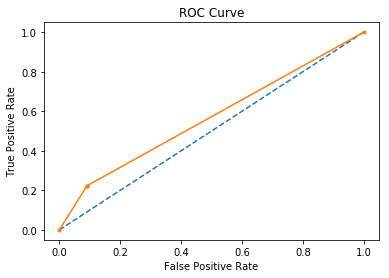

In [12]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB().fit(train_features, train_response)
y_pred = NB.predict(test_features)
model_eval(test_response, y_pred)

plot_roc_curve(NB, test_features, test_response)

## Neural Network

In [13]:
ANN = MLPClassifier()
ANN.fit(train_features_Z, train_response_Z)
y_pred = ANN.predict(test_features_Z)
model_eval(test_response_Z, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,128048,31938
Order Success,1345,7100




               precision    recall  f1-score   support

   Order Fail       0.99      0.80      0.88    159986
Order Success       0.18      0.84      0.30      8445

  avg / total       0.95      0.80      0.86    168431



## Linear SVC

In [17]:
SVC = svm.LinearSVC()
SVC.fit(train_features, train_response)
y_pred = SVC.predict(test_features)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,158303,1683
Order Success,8295,150




               precision    recall  f1-score   support

   Order Fail       0.95      0.99      0.97    159986
Order Success       0.08      0.02      0.03      8445

  avg / total       0.91      0.94      0.92    168431



# AdaBoost Models

### Boosted Random Forest

In [15]:
AB = AdaBoostClassifier(RandomForestClassifier())
AB.fit(train_features, train_response)
y_pred = AB.predict(test_features)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,129596,30390
Order Success,1094,7351




               precision    recall  f1-score   support

   Order Fail       0.99      0.81      0.89    159986
Order Success       0.19      0.87      0.32      8445

  avg / total       0.95      0.81      0.86    168431



### Boosted Linear SVC

In [16]:
AB = AdaBoostClassifier(svm.LinearSVC(), algorithm='SAMME')
AB.fit(train_features, train_response)
y_pred = AB.predict(test_features)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,155614,4372
Order Success,7901,544




               precision    recall  f1-score   support

   Order Fail       0.95      0.97      0.96    159986
Order Success       0.11      0.06      0.08      8445

  avg / total       0.91      0.93      0.92    168431



### ANN cannot be boosted with AdaBoost

### Boosted Naive Bayes

In [91]:
AB = AdaBoostClassifier(MultinomialNB())
AB.fit(train_features, train_response)
y_pred = AB.predict(test_features)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,150099,9897
Order Success,7648,787




               precision    recall  f1-score   support

   Order Fail       0.95      0.94      0.94    159996
Order Success       0.07      0.09      0.08      8435

  avg / total       0.91      0.90      0.90    168431



### Boosted Logistic Regression

In [92]:
AB = AdaBoostClassifier(LogisticRegression())
AB.fit(train_features, train_response)
y_pred = AB.predict(test_features)
model_eval(test_response, y_pred)



CONFUSION MATRIX (predicted along top, actual along side): 


,Order Fail,Order Success
Order Fail,116053,43943
Order Success,1818,6617




               precision    recall  f1-score   support

   Order Fail       0.98      0.73      0.84    159996
Order Success       0.13      0.78      0.22      8435

  avg / total       0.94      0.73      0.80    168431

